# Image transforms

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [3]:
transform0 = transforms.Resize((28,28)) # resize our images, only useful for test images as all the images from training are already at correct size
transform1 = transforms.ToTensor() #transform our np array (range 0 to 255) into a tensor in the range from 0 to 1
transform2 = transforms.Normalize((0.5,), (0.5,)) #frst bracket is mean, second is standard deviation. Now our data goes from -1 to 1
transform = transforms.Compose([transform0, transform1, transform2]) # chain transformations

training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) #download and apply transformation to our dataset
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform) #download and apply transformation to our dataset


training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=100, shuffle=True) # loads 100 samples per batch / shuffle is used so that the data is shuffled at each epoch. Note that our dataset is big here so i will have a lot of iterations before completing one epoch
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=100, shuffle=False)

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() #1*28*28
    # image = image.transpose(1,2) #28*28*1
    image = image[0]
    image = image * np.array([0.5])+ np.array([0.5]) #reverse normalisation
    image.clip(0,1) #ensures range is between 0 and 1
    return image


torch.Size([100, 1, 28, 28]) torch.Size([100])


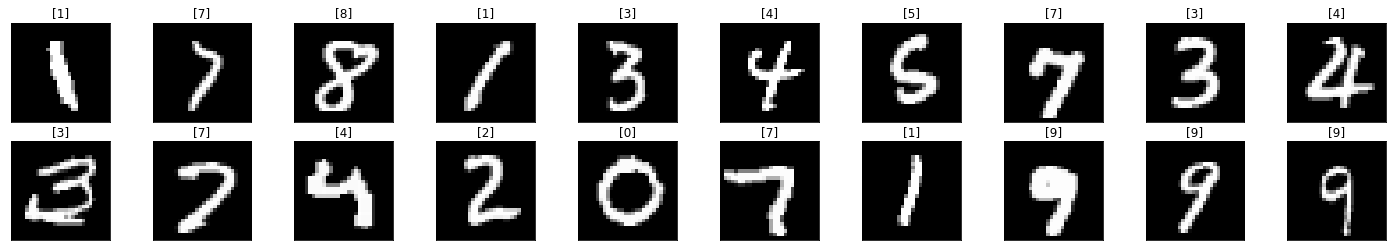

In [4]:
dataiter = iter(training_loader) #iterable created from training_loader. Each time i call next, i get 100 points (list of X (images of size 1*28*28) and y (values))
images, labels = dataiter.next()
print(images.shape, labels.shape)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap="gray")
    ax.set_title([labels[idx].item()])


# neural network implementation

In [5]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    
    def activate(self, a, activation, func):
        intermediate = func(a)
        return activation(intermediate)

    def forward(self,x):
        a1 = nn.functional.relu(self.linear1(x))
        a2 = nn.functional.relu(self.linear2(a1))
        score = self.linear3(a2) #raw score here
        return score

       

In [6]:
model = Classifier(784, 125, 65, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.0001)
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader: #this time i dont do my whole batch at once : multiple updates per epochs
        #les inputs sont de dimension 100 * 1 * 28 * 28 (100 mesures, 1 channel, 28*28 pixels)
        inputs = inputs.view(inputs.shape[0],-1) #je garde les mesures en colonne et je flatten le reste
        outputs = model.forward(inputs) # je prédis l'output de 100 imgs à la fois. Là encore, jsi je voulais ne prédire qu'une image, je pourrais supprimer la dimension des mesures
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels)
    else:
    #runs after for loop ends. not rly useful 
        with torch.no_grad():
        # no need to compute derivative on validation set so we save memory
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0],-1)
                val_outputs = model.forward(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)



    epoch_loss = running_loss/len(training_loader) # en fait c'est pas parfait. Il vaudrait mieux multiplier la val_running_loss par le nombre d'items passé à chaque fois puis diviser par le nombre total d'image. Comme ça on évite le pb du dernier batch size qui a une taille différente. Mais bon, c'est quasi pareil
    # puis à la fin diviser par len
    epoch_acc = running_corrects/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader) 
    val_epoch_acc = val_running_corrects/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))


training loss: 0.009326, accuracy : 0.776950
validation loss: 0.004273, accuracy : 0.885800
training loss: 0.003854, accuracy : 0.892983
validation loss: 0.003276, accuracy : 0.904500
training loss: 0.003249, accuracy : 0.906817
validation loss: 0.002938, accuracy : 0.914400
training loss: 0.002934, accuracy : 0.915817
validation loss: 0.002743, accuracy : 0.920400
training loss: 0.002686, accuracy : 0.922017
validation loss: 0.002500, accuracy : 0.927300
training loss: 0.002457, accuracy : 0.928800
validation loss: 0.002378, accuracy : 0.929600
training loss: 0.002244, accuracy : 0.934983
validation loss: 0.002106, accuracy : 0.936900
training loss: 0.002056, accuracy : 0.940917
validation loss: 0.001991, accuracy : 0.941900
training loss: 0.001908, accuracy : 0.944983
validation loss: 0.001835, accuracy : 0.947700
training loss: 0.001767, accuracy : 0.948950
validation loss: 0.001748, accuracy : 0.948700
training loss: 0.001650, accuracy : 0.952083
validation loss: 0.001629, accuracy

In [1]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")

NameError: name 'plt' is not defined

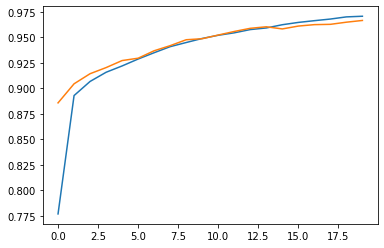

In [8]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")

# Final tests

<Response [200]>


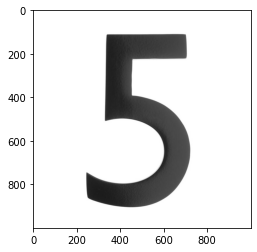

In [12]:
import requests
import PIL
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
img = PIL.Image.open(response.raw)
print(response)
plt.imshow(img)

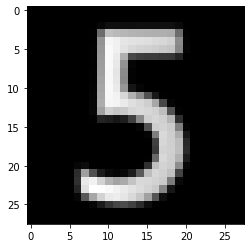

In [15]:
# problems : our network was trained with images with black background and white foreground
def img_transform(img):
    img = PIL.Image.open(img)
    img = PIL.ImageOps.invert(img)
    img = PIL.ImageOps.grayscale(img)
    img = transform(img) # apply the transform defined on top
    return img


response = requests.get(url, stream=True)
img = img_transform(response.raw)
plt.imshow(img[0], cmap='gray')

In [14]:
test_outputs = model.forward(img.view(1,-1))
pred = torch.max(test_outputs,1)
pred

torch.return_types.max(
values=tensor([7.5328], grad_fn=<MaxBackward0>),
indices=tensor([5]))

torch.return_types.max(
values=tensor([7.7814], grad_fn=<MaxBackward0>),
indices=tensor([8]))

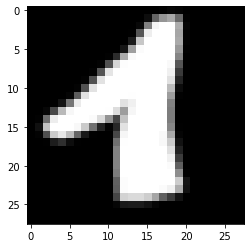

In [32]:
img = img_transform("data/paint/onethickpaint.png")
plt.imshow(img[0], cmap='gray')
test_outputs = model.forward(img.view(1,-1))
pred = torch.max(test_outputs,1)
pred

# sucks on my data